# SVM - Support Vector Machine

Importing libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from ipynb.fs.defs.additional_metrics import *


Defining functions that will perform .fit() and .predict() while calculating execution time

In [2]:
def svc_fit_with_time(svc, X_trainCV, y_trainCV, time_fit_tmp):
    start = time.time()     
    svc.fit(X_trainCV, y_trainCV)
    time_fit_tmp.append(time.time()-start)

In [3]:
def svc_predict_with_time(svc, X_testCV, time_pred_tmp):
    start = time.time()
    y_pred = svc.predict(X_testCV)
    time_pred_tmp.append(time.time()-start)
    return y_pred

## Trained on 30% samples of the original training dataset

In [4]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [5]:
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_train_std, y_train, test_size=0.7, stratify=y_train, random_state=42)

In [6]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
acc = []
i, p_val, best_acc, best_c = 0, 0, 0, 0
best_k, best_g = '', ''

for c in [0.1, 0.5, 1, 3, 5, 6, 7, 8, 9, 10, 13, 15, 20, 50]:
    for k in ["linear", "poly", "rbf", "sigmoid"]:
        for g in ["scale", "auto"]:
            
            acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []
 
            indexes = kf.split(X_train_30, y_train_30)

            for train_index, test_index in indexes:

                X_trainCV1 = X_train_30.iloc[train_index,:]
                y_trainCV1 = y_train_30.iloc[train_index]
                X_testCV1 = X_train_30.iloc[test_index,:]
                y_testCV1 = y_train_30.iloc[test_index]

                classifier1 = SVC(C = c, kernel = k, gamma = g)
                
                svc_fit_with_time(classifier1, X_trainCV1, y_trainCV1, time_fit_tmp)
                y_pred1 = svc_predict_with_time(classifier1, X_testCV1, time_pred_tmp)

                c1 = confusion_matrix(y_testCV1, y_pred1)
                acc_tmp.append(np.trace(c1)/sum(sum(c1)))
            
            print(f"{i+1}. C = {c}, k = {k}, g = {g}, Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")
            acc.append(np.mean(acc_tmp))
            i += 1

            if np.mean(acc_tmp) > best_acc:
                best_acc = np.mean(acc_tmp)
                best_c, best_k, best_g = c, k, g
            
    print('')

print('-------------------')
print('Best accuracy is in iteration number:', np.argmax(acc) + 1, ' | for c =', best_c, ', k =', best_k, ', g =', best_g)

1. C = 0.1, k = linear, g = scale, Average accuracy: 0.831500 | Average fit time: 19.268941s | Average predict time: 6.539754s
2. C = 0.1, k = linear, g = auto, Average accuracy: 0.831500 | Average fit time: 18.454200s | Average predict time: 6.364394s
3. C = 0.1, k = poly, g = scale, Average accuracy: 0.747444 | Average fit time: 62.797325s | Average predict time: 11.727475s
4. C = 0.1, k = poly, g = auto, Average accuracy: 0.746056 | Average fit time: 62.535731s | Average predict time: 11.631388s
5. C = 0.1, k = rbf, g = scale, Average accuracy: 0.808833 | Average fit time: 40.701054s | Average predict time: 16.985062s
6. C = 0.1, k = rbf, g = auto, Average accuracy: 0.808833 | Average fit time: 40.695049s | Average predict time: 17.016091s
7. C = 0.1, k = sigmoid, g = scale, Average accuracy: 0.778000 | Average fit time: 36.663778s | Average predict time: 11.100905s
8. C = 0.1, k = sigmoid, g = auto, Average accuracy: 0.778556 | Average fit time: 36.969858s | Average predict time: 1

#### Checking if other parameters speed up the process

In [7]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_time_fit = 99999
best_dfs, best_s = '', False

for dfs in ["ovo", "ovr"]:
    for s in [True, False]:

        acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []
            
        indexes = kf.split(X_train_30, y_train_30)
 
        for train_index, test_index in indexes:

            X_trainCV1 = X_train_30.iloc[train_index,:]
            y_trainCV1 = y_train_30.iloc[train_index]
            X_testCV1 = X_train_30.iloc[test_index,:]
            y_testCV1 = y_train_30.iloc[test_index]

            classifier1 = SVC(C = best_c, kernel = best_k, gamma = best_g, shrinking = s, decision_function_shape = dfs)
                
            svc_fit_with_time(classifier1, X_trainCV1, y_trainCV1, time_fit_tmp)
            y_pred1 = svc_predict_with_time(classifier1, X_testCV1, time_pred_tmp)

            c1 = confusion_matrix(y_testCV1, y_pred1)
            acc_tmp.append(np.trace(c1)/sum(sum(c1)))
        
        print(f"dfs = {dfs}, s = {s} Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")
         
        if np.mean(time_fit_tmp) < best_time_fit:
            best_time_fit = np.mean(time_fit_tmp)
            best_dfs, best_s = dfs, s

print('')    
print('-------------------')
print(f'Best accuracy is for dfs = {best_dfs}, s = {best_s}')

dfs = ovo, s = True Average accuracy: 0.882333 | Average fit time: 24.565364s | Average predict time: 12.694957s
dfs = ovo, s = False Average accuracy: 0.882333 | Average fit time: 25.234373s | Average predict time: 12.670535s
dfs = ovr, s = True Average accuracy: 0.882333 | Average fit time: 24.668593s | Average predict time: 12.764621s
dfs = ovr, s = False Average accuracy: 0.882333 | Average fit time: 24.973335s | Average predict time: 12.678542s

-------------------
Best accuracy is for dfs = ovo, s = True


#### Training on 30% training samples, test on test dataset

In [8]:
classifier1 = SVC(C = best_c, kernel = best_k, gamma = best_g, decision_function_shape = best_dfs, shrinking = best_s)

start1 = time.time()
classifier1.fit(X_train_30, y_train_30)
fit_time = time.time() - start1

start2 = time.time()
y_pred2 = classifier1.predict(X_test_std)
pred_time = time.time() - start2

c2 = confusion_matrix(y_test, y_pred2, labels=[0,1,2,3,4,5,6,7,8,9])
    
print(f"Accuracy: {np.trace(c2)/sum(sum(c2)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('SVC parameters: c = ', best_c, ', k = ', best_k, ', g = ', best_g, ', dfs = ', best_dfs, ', s = ', best_s, sep='')

Accuracy: 0.888000 | Average fit time: 37.596225s | Average predict time: 42.276487s
-------------------
SVC parameters: c = 7, k = rbf, g = auto, dfs = ovo, s = True


.

## Trained on 100% samples of the original training dataset

In [9]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc, acc_tmp, time_fit_tmp, time_pred_tmp = [], [], [], []
     
indexes = kf.split(X_train, y_train)

for train_index, test_index in indexes:
    
    X_trainCV2 = X_train_std.iloc[train_index,:]
    y_trainCV2 = y_train.iloc[train_index]
    X_testCV2 = X_train_std.iloc[test_index,:]
    y_testCV2 = y_train.iloc[test_index]

    classifier2 = SVC(C = best_c, kernel = best_k, gamma = best_g, decision_function_shape = best_dfs, shrinking = best_s)
                
    svc_fit_with_time(classifier2, X_trainCV2, y_trainCV2, time_fit_tmp)
    y_pred3 = svc_predict_with_time(classifier2, X_testCV2, time_pred_tmp)

    c3 = confusion_matrix(y_testCV2, y_pred3)
    acc_tmp.append(np.trace(c3)/sum(sum(c3)))

    print(f"        Accuracy: {np.trace(c3)/sum(sum(c3)):.6f} | Fit time: {time_fit_tmp[-1]:.6f}s | Predict time: {time_pred_tmp[-1]:.6f}s")

print("")    
print('-------------------')
print(f"Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")

        Accuracy: 0.903083 | Fit time: 210.711826s | Predict time: 109.540723s
        Accuracy: 0.898917 | Fit time: 210.422563s | Predict time: 110.718795s
        Accuracy: 0.902167 | Fit time: 212.584531s | Predict time: 110.518613s
        Accuracy: 0.901833 | Fit time: 210.206366s | Predict time: 110.185310s
        Accuracy: 0.901167 | Fit time: 209.188439s | Predict time: 109.105326s

-------------------
Average accuracy: 0.901433 | Average fit time: 210.622745s | Average predict time: 110.013753s


##### Training on 100% training samples, test on test dataset

In [11]:
classifier2 = SVC(C = best_c, kernel = best_k, gamma = best_g, decision_function_shape = best_dfs, shrinking = best_s)

start1 = time.time()
classifier2.fit(X_train_std, y_train)
fit_time = time.time() - start1

start2 = time.time()
y_pred4 = classifier2.predict(X_test_std)
pred_time = time.time() - start2

c4 = confusion_matrix(y_test, y_pred4, labels=[0,1,2,3,4,5,6,7,8,9])
    
print(f"Accuracy: {np.trace(c4)/sum(sum(c4)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('SVC parameters: c = ', best_c, ', k = ', best_k, ', g = ', best_g, ', dfs = ', best_dfs, ', s = ', best_s, sep='')

Accuracy: 0.907600 | Average fit time: 311.328423s | Average predict time: 109.880032s
-------------------
SVC parameters: c = 7, k = rbf, g = auto, dfs = ovo, s = True


.

## Trained on 100% samples with PCA reduction

In [12]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [13]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
acc = []
i, p_val, best_acc, best_c, best_pca = 0, 0, 0, 0, 0
best_k = ''
best_g = 'scale'

for c in [0.1, 0.5, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20]:
    # stopped and excluded "linear" because of extremely high execution times
    # pc for  0.9 gave better results than every other value
    for k in ["poly", "rbf"]:
        for pc in [0.9]:
    
            acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []

            indexes = kf.split(X_train, y_train)

            for train_index, test_index in indexes:

                X_trainCV3 = X_train_std.iloc[train_index,:]
                y_trainCV3 = y_train.iloc[train_index]
                X_testCV3 = X_train_std.iloc[test_index,:]
                y_testCV3 = y_train.iloc[test_index]

                pca = PCA(n_components=pc)
                pca.fit(X_trainCV3)
                X_train_r = pca.transform(X_trainCV3)
                X_test_r = pca.transform(X_testCV3)

                classifier3 = SVC(C = c, kernel = k, gamma = best_g)
                
                svc_fit_with_time(classifier3, X_train_r, y_trainCV3, time_fit_tmp)
                y_pred5 = svc_predict_with_time(classifier3, X_test_r, time_pred_tmp)

                c5 = confusion_matrix(y_testCV3, y_pred5)
                acc_tmp.append(np.trace(c5)/sum(sum(c5)))

            print(f"{i+1}. pca = {pc:.6f}, C = {c}, k = {k}, Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")
            acc.append(np.mean(acc_tmp))
            i += 1

            if np.mean(acc_tmp) > best_acc:
                best_acc = np.mean(acc_tmp)
                best_c, best_k, best_pca = c, k, pc
            
    print('')

print('-------------------')
print('Best accuracy is in iteration number:', np.argmax(acc) + 1, ' | for c =', best_c, ', k =', best_k, ', g = scale, pca =', best_pca)

1. pca = 0.900000, C = 0.1, k = poly, Average accuracy: 0.818050 | Average fit time: 126.109807s | Average predict time: 24.114553s
2. pca = 0.900000, C = 0.1, k = rbf, Average accuracy: 0.847967 | Average fit time: 90.653327s | Average predict time: 37.059538s

3. pca = 0.900000, C = 0.5, k = poly, Average accuracy: 0.864700 | Average fit time: 75.771780s | Average predict time: 18.285847s
4. pca = 0.900000, C = 0.5, k = rbf, Average accuracy: 0.878050 | Average fit time: 64.025086s | Average predict time: 29.621166s

5. pca = 0.900000, C = 1, k = poly, Average accuracy: 0.878117 | Average fit time: 64.589000s | Average predict time: 16.613324s
6. pca = 0.900000, C = 1, k = rbf, Average accuracy: 0.886500 | Average fit time: 58.662003s | Average predict time: 27.582310s

7. pca = 0.900000, C = 3, k = poly, Average accuracy: 0.889367 | Average fit time: 53.606602s | Average predict time: 14.331247s
8. pca = 0.900000, C = 3, k = rbf, Average accuracy: 0.895467 | Average fit time: 53.803

#### Checking if other parameters speed up the process

In [14]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_time_fit = 99999
best_dfs, best_s = '', False

for dfs in ["ovo", "ovr"]:
    for s in [True, False]:
    
        acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []

        indexes = kf.split(X_train, y_train)

        for train_index, test_index in indexes:

            X_trainCV3 = X_train_std.iloc[train_index,:]
            y_trainCV3 = y_train.iloc[train_index]
            X_testCV3 = X_train_std.iloc[test_index,:]
            y_testCV3 = y_train.iloc[test_index]

            pca = PCA(n_components = best_pca)
            pca.fit(X_trainCV3)
            X_train_r = pca.transform(X_trainCV3)
            X_test_r = pca.transform(X_testCV3)

            classifier3 = SVC(C = best_c, kernel = best_k, gamma = best_g, shrinking = s, decision_function_shape = dfs)
                
            svc_fit_with_time(classifier3, X_train_r, y_trainCV3, time_fit_tmp)
            y_pred5 = svc_predict_with_time(classifier3, X_test_r, time_pred_tmp)

            c5 = confusion_matrix(y_testCV3, y_pred5)
            acc_tmp.append(np.trace(c5)/sum(sum(c5)))
        
        print(f"dfs = {dfs}, s = {s} Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")
         
        if np.mean(time_fit_tmp) < best_time_fit:
            best_time_fit = np.mean(time_fit_tmp)
            best_dfs, best_s = dfs, s

print('')    
print('-------------------')
print(f'Best accuracy is for dfs = {best_dfs}, s = {best_s}')

dfs = ovo, s = True Average accuracy: 0.900583 | Average fit time: 51.922269s | Average predict time: 24.014462s
dfs = ovo, s = False Average accuracy: 0.900583 | Average fit time: 57.901912s | Average predict time: 23.983434s
dfs = ovr, s = True Average accuracy: 0.900583 | Average fit time: 51.746909s | Average predict time: 24.049894s
dfs = ovr, s = False Average accuracy: 0.900583 | Average fit time: 57.873687s | Average predict time: 24.031278s

-------------------
Best accuracy is for dfs = ovr, s = True


##### Training on 100% training samples with PCA reduction, test on test dataset

In [15]:
best_pca = 0.9
best_s = True
best_dfs = "ovr"
best_c = 13 
best_k = "rbf"  
best_g = "scale"

In [16]:
pca = PCA(n_components=best_pca)
pca.fit(X_train_std)
X_train_r = pca.transform(X_train_std)
X_test_r = pca.transform(X_test_std)


classifier3 = SVC(C = best_c, kernel = best_k, gamma = best_g, shrinking = best_s, decision_function_shape = best_dfs)

start1 = time.time()
classifier3.fit(X_train_r, y_train) 
fit_time = time.time() - start1

start2 = time.time()
y_pred6 = classifier3.predict(X_test_r)
pred_time = time.time() - start2

c6 = confusion_matrix(y_test, y_pred6, labels=[0,1,2,3,4,5,6,7,8,9])
    
print(f"Accuracy: {np.trace(c6)/sum(sum(c6)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('SVC parameters: c = ', best_c, ', k = ', best_k, ', g = ', best_g, ', dfs = ', best_dfs, ', s = ', best_s, ', pca = ', best_pca, sep='')            

Accuracy: 0.906900 | Average fit time: 95.116445s | Average predict time: 24.543729s
-------------------
SVC parameters: c = 13, k = rbf, g = scale, dfs = ovr, s = True, pca = 0.9


In [17]:
# confusion matrix
print(c6)

[[874   0  14  19   0   0  85   0   8   0]
 [  3 983   2  11   0   0   0   0   1   0]
 [ 14   0 843  11  70   0  56   0   6   0]
 [ 16   7   7 930  25   1  13   0   1   0]
 [  1   0  57  23 865   0  53   0   1   0]
 [  0   0   0   0   0 953   1  28   7  11]
 [122   0  68  25  50   0 723   0  12   0]
 [  0   0   0   0   0  13   0 962   0  25]
 [  7   0   4   2   1   1   3   1 980   1]
 [  1   0   0   0   0   7   0  34   2 956]]


In [18]:
print(accuracy_per_class(c6, y_test.unique()))

For class 0 accuracy is: 0.971
For class 1 accuracy is: 0.9976
For class 2 accuracy is: 0.9691
For class 3 accuracy is: 0.9839
For class 8 accuracy is: 0.9719
For class 6 accuracy is: 0.9931
For class 5 accuracy is: 0.9512
For class 4 accuracy is: 0.9899
For class 7 accuracy is: 0.9942
For class 9 accuracy is: 0.9919
-------------
0.9813799999999999


In [19]:
print(sensitivity_per_class(c6, y_test.unique()))

For class 0 sensitivity is: 0.874
For class 1 sensitivity is: 0.983
For class 2 sensitivity is: 0.843
For class 3 sensitivity is: 0.93
For class 8 sensitivity is: 0.865
For class 6 sensitivity is: 0.953
For class 5 sensitivity is: 0.723
For class 4 sensitivity is: 0.962
For class 7 sensitivity is: 0.98
For class 9 sensitivity is: 0.956
-------------
0.9068999999999999


## Examples of wrong classification

In [20]:
y_pred_np = y_pred6
print(type(y_pred6))

y_test_np = y_test.to_numpy()
print(type(y_test_np))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
def differences(a,b):
    list = []
    for j in range(len(a)):
        if b[j] != a[j]:
            list = list + [j]        
    arrayIndexes = np.asarray(list)
    return arrayIndexes

In [22]:
diff = differences(y_pred_np, y_test_np)
print(diff[:9])

[ 5  7 38 40 43 51 58 59 72]


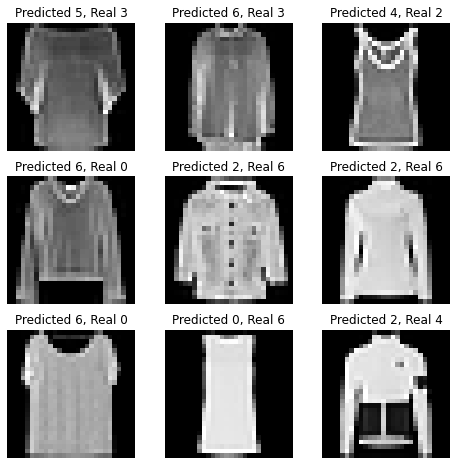

In [23]:
plt.figure(figsize=(8,8))

for j in range(0,9):  
    plt.subplot(3,3,j+1)    
    arr = X_test.iloc[diff[j],:].to_numpy()
    
    arr = arr.reshape(28,28)
    arr = arr.astype(np.uint8)
    img = Image.fromarray(arr, "L")
    
    plt.imshow(img, cmap = 'gray')
    plt.title(f"Predicted {y_pred_np[diff[j+100]]}, Real {y_test_np[diff[j+100]]}")
    plt.axis("off")

plt.show()